# Basic Tutorial
The Thevenin package is built around three main classes:

1. `Model` - used to construct instances of an equivalent circuit.
2. `Experiment` - used to define an experimental protocol containing current, voltage, and/or power-controlled steps.
3. `Solution` - the result object(s) that contain simulation outputs when a particular model runs a particular experiment.

Each of these classes exist at the base package level so they are easily accessible. In this tutorial you will be introduced to each of class through a minimal example. The example will demonstrate a typical workflow for constructing a model, defining an experiment, and interacting with the solution.

## Construct a Model
The model class is constructed by providing options and parameters that define your circuit. The input can be given as either a dictionary or using a `.yaml` file. If you do not give an input, we include a default parameters file for you to get started. However, it is important that you understand this file and/or its dictionary equivalent so you can modify parameter definitions as necessary later. For more information about constructing model inputs, see the {ref}`examples <examples>` section.

Here, we will start by simply using the default parameters. A warning will print when the default parameters are accessed, but we can ignore it. After initialization, the class can be printed to check all of the constant options/parameters. The model also contains functional parameters, i.e., properties that change as a function of state of charge (soc) and/or temperature. These values are difficult to represent in the printed output so they are not displayed.

In [3]:
import thevenin

model = thevenin.Model()
print(model)

Model(
	num_RC_pairs=1,
	soc0=1.0,
	capacity=75.0,
	mass=1.9,
	isothermal=False,
	Cp=745.0,
	T_inf=300.0,
	h_therm=12.0,
	A_therm=1.0,
)


Options and parameters can be changed after initialization by modifying the corresponding attribute. However, if you modify anything after initialization, you should ALWAYS run the preprocessor `pre()` method afterward. This method is run automatically when the class is first initialized, but needs to be run again manually in some cases. One such case is when options and/or parameters are changes. Forgetting to do this will cause the internal state and options to not be self consistent. We demonstrate the correct way to make changes below, by setting the `isothermal` option to `True`.

In [2]:
model.isothermal = True 
model.pre()

## Define an Experiment
The model has two methods, `run()` and `run_step()` that correspond to the steps of the `Experiment` class. Similar to how a typical battery cycler would be programmed, an experiment is built by defining a series of sequential steps. Each step has its own mode (current, voltage, or power), value, time span, and limiting criteria.

While we will not cover solver options in this tutorial, you should know that these options exist and are controlled through the `Experiment` class. Options that should be consistent throughout all steps should be set with keyword arguments when the class instance is created. You can also modify solver options at the per-step level (e.g., tighter tolerances) if needed. For more information, see the full documentation.

Below we construct an experiment instance with two simple steps. The first step discharges the battery at a constant current until it reaches 3 V. Afterward, the battery rests for 10 minutes. Note that the sign convention for current and power are such that positive values discharge the cell and negative values charge the cell.

In [3]:
expr = thevenin.Experiment()
expr.add_step('current_A', 75., (4000., 60.), limits=('voltage_V', 3.))
expr.add_step('current_A', 0., (600., 60.))

There are also control modes available for both voltage and power, and while we do not demonstrate it here, the load value does not need to be constant. By passing in a callable like `f(t) -> float` where `t` is time and the return value is your load at that time, you can also run a dynamic profiles within a step. 

Pay attention to two important details in the example above:

1. The `tspan` input (third argument) uses 4000 seconds in the first step even though the current is chosen such that the battery should dischange within an hour. When `limits` is used within a step, and you want to guarantee the limit is actually reached, you will want to pick a time beyond when you expect the limiting event to occur.
2. The value `60.` in the second position of the `tspan` argument contains a trailing decimal on purpose. When the decimal is present, Python interprets this as a float rather than an integer. The time step behavior is sensitive to this. When a float is passed, the solution is saved in intervals of this value (here, every 60 seconds). If an integer is passed instead, the full timespan is split into that number of times. In otherwords, `dt = tspan[0] / (tspan[1] - 1)`. We recommend always use floats for steps that have limits.

## Run the Simulation
As mentioned above, the model contains two methods to run an experiment. You can either run the entire series of experiment steps by calling `run()`, or you can run one step at a time by calling `run_step()`. The most important difference between the two is that the model's internal state is changed and saved at the end of each step when using `run_step()` so that it is ready for the following step. Therefore, steps should only ever be run in sequential order, and steps between multiple experiments should not be mixed. For example, to run the above two steps one at a time, run the following code.

In [4]:
soln_0 = model.run_step(expr, 0)
soln_1 = model.run_step(expr, 1)

Indexing starts at zero to be consistent with the Python language. When steps are run one at a time, the output will be a `StepSolution`, which we discuss more below. 

It is common to setup multiple experiments that you'd like a model to run and to loop over them. For example, maybe you want to simulate different discharge rates using one experiment per rate. When using the `run()` method, you can do these back-to-back without much thought, however, when using `run_step()`, the `pre()` method should always be called before switching to another experiment. Otherwise, after the first experiment, the internal state will be at `soc = 0` and when the following experiment tries to discharge the cell at a higher rate, the results will not be physical. Likely this will lead to a crash. Therefore, before we demonstrate the `run()` method, we will call `pre()` to reset the model state from the steps run above.

In [5]:
model.pre()

soln = model.run(expr)

## Interacting with Solutions
Simulation outputs will give one of two solution objects depending on your run mode. A `StepSolution` is returned when you run step by step and a `CycleSolution` is returned when using `run()`. The latter simply stitches together the individual step solutions. Each solution object has numerous attributes to inform the user whether or not their simulation was successful, how long the integrator took, etc. For `CycleSolution` instances, most of these values are lists where each index corresponds to experimental steps with the same indices. For example, below we see that both steps were successful and the total integration time.

In [6]:
print(f"success = {soln.success}")
print(soln.solvetime)

success = [True, True]
Solve time: 0.007 s


Most likely, everything else you will need to extract from solutions can be found in the solution's `vars` dictionary. This dictionary contains easy to read names and units for all of the model's outputs. You can always check the keys to this dictionary by printing the solution instance.

In [7]:
print(soln)

dict_keys(['time_s', 'time_min', 'time_h', 'soc', 'temperature_K', 'voltage_V', 'current_A', 'power_W', 'capacity_Ah', 'eta0_V', 'eta1_V'])


All values in the `vars` dictionary are 1D arrays that provide the values of the named variable at each integrator step. You can plot any two variables against each other using the `plot()` method. For example, to see voltage plotted against time, see below.

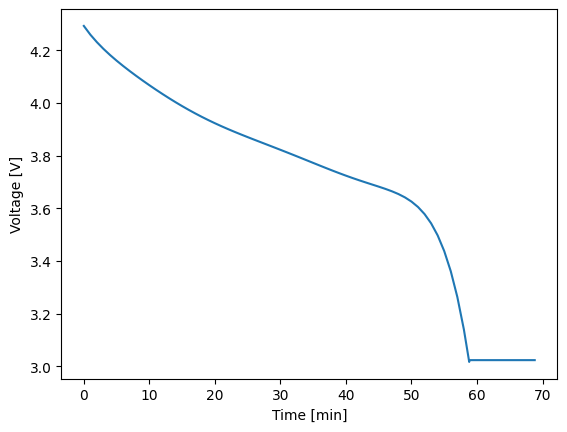

In [8]:
soln.plot('time_min', 'voltage_V')

It can also be helpful to extract portions of a `CycleSolution` to examine what occurred within a given step, or to combine `StepSolution` instances so that you can post process or plotting purposes. Both of these features are available, as shown below.

In [9]:
soln_0 = soln.get_steps(0)
soln_1 = soln.get_steps(1)

soln = thevenin.CycleSolution(soln_0, soln_1)